In [12]:
import pandas as pd

from pycaret.classification import *
from src.Utils.tools import *

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
raw_df = pd.read_csv('Datasets/Full-Data-Set-UnderOver-2021-22.csv')

In [14]:
pp_df = clean_train_data(raw_df)

In [18]:
win_loss_results, ou_results = predict(pp_df)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [125]:
def simulate_betting(dic_result,start_date=None,start_out_amount=0,amount_per_bet=10,home_win_threshold=0.5):
    
    init_amount=start_out_amount
    
    if start_date:
        dic_result = [dic for dic in dic_result if dic['date'] >= start_date]
    
    dic_result.sort(key = lambda x:x['date'])

    for game in dic_result:

        home = game['home']
        away = game['away']

        prob_home_win = game['Score_W']
        prob_away_win = game['Score_L']

        ev_home = game['home_team_ml_expected_value']
        ev_away = game['away_team_ml_expected_value']

        ml_home = game['ml_home']
        ml_away = game['ml_away']

        actual_wl = game['home-team-win']

        # Determine which team to bet
        if prob_home_win > prob_away_win:

            bet_team = home
            bet_prob = prob_home_win
        else:

            bet_team = away
            bet_prob = prob_away_win

        # Determine if team betting meets prob threshold
        if bet_prob >= home_win_threshold:

            # Win if bet team is the home team home team wins
            if bet_team == home and actual_wl == 'W':

                ml = ml_home
                bet_result = 'Win'

            # Win if bet team is away the home team loses
            elif bet_team == away and actual_wl == 'L':

                ml = ml_away
                bet_result = 'Win'

            else:

                bet_result = 'Loss'

            # If win, decided on win amount
            if bet_result == 'Win':

                if ml < 0:

                    win_pct = amount_per_bet/(abs(ml))

                    win_amount = amount_per_bet * win_pct

                    start_out_amount += win_amount

                else:

                    start_out_amount += ml

            # If loss, decide on loss amount
            else:

                start_out_amount -= amount_per_bet
        else:

            bet_result = 'No bets'

        game['bet_prob'] = bet_prob
        game['bet_team'] = bet_team
        game['bet_result'] = bet_result
        game['bet_balance'] = start_out_amount  
    
    wins = pd.DataFrame(dic_result)['bet_result'].value_counts()['Win']

    loss = pd.DataFrame(dic_result)['bet_result'].value_counts()['Loss']

    no_bets = pd.DataFrame(dic_result)['bet_result'].value_counts()['No bets']
    
    win_pct = round(wins/(wins+loss)*100,2)
    final_winnings = dic_result[-1]['bet_balance']
    winning_difference = round(float(final_winnings)-init_amount,2)
    total_days = (datetime.strptime(dic_result[-1]['date'], '%Y-%m-%d') - datetime.strptime(dic_result[0]['date'], '%Y-%m-%d')).days
    total_investment = amount_per_bet*(wins+loss)
    investment_per_day = round(total_investment/total_days,2)
    investment_per_month = round(investment_per_day * 30,2)
    bet_per_day = round((wins+loss)/total_days)
    
    print(f'Win Percentage: {win_pct}%')
    print(f'Balance Difference: ${winning_difference}')
    print(f'Bet per day: {bet_per_day}')
    print(f'Investment per day: ${investment_per_day}')
    print(f'Investment per month: ${investment_per_month}')
    pd.DataFrame(dic_result).plot(x='date',y='bet_balance')
        
    return dic_result

Win Percentage: 81.45%
Balance Difference: $33630.63
Bet per day: 1
Investment per day: $6.84
Investment per month: $205.2


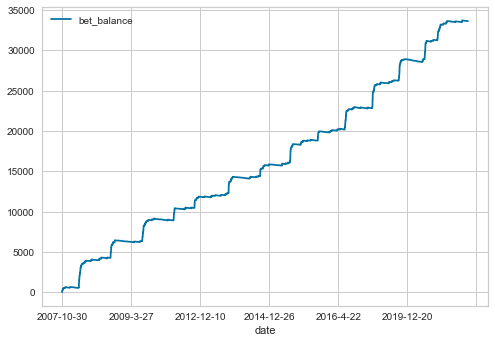

In [126]:
result_dict=simulate_betting(win_loss_results,
#                              start_date= '2020-1-1',
                             start_out_amount=0,
                             amount_per_bet=5,
                             home_win_threshold=0.7)